# 프로젝트 의의:
제무제표는 후행지표이기 때문에 선행성을 가진 주가를 예측하는데 사용하기 힘든 부분이 있음<br>
제무제표를 확인하여 투자할 수 있는 방법은 고정비가 많이 ~

# 프로젝트 목표:
* 상품의 원재료(석유) 비중이 70% 이상인 기업의 주가들을 하나의 지수로 만들어 선행지표인 석유가격을 활용하여<br>
딥러닝을 통해 석유지수를 예측해보려함<br>
* 주가는 대표적인 비정상시계열이므로 단변량으로 추세 예측 불가능. 따라서 석유가격을 사용한 Multivaraible 모델을 <br>
사용할 계획
* 이를 통해 매일매일 수익률을 확인할 수 있는 프로그램 배포까지 진행할 예정

# 활용 데이터
* 기간: 현재로부터 최근 5년 
* 종류: 석유 관련 기업 주가 데이터, 두바이유 선물

In [ ]:
# 지수 구하기
# 해야할것 
# 날짜별 비교시점 시가총액합/ 기준시점시가총액 합
# 정유주 별 지수
# 윤활유주 지수
# 석유화학주 지수
# 전체지수

# Version 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import sklearn
import tensorflow as tf
import tensorflow_probability as tfp
import sys

print
print("python: ", sys.version)
print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("seaborn: ", sns.__version__)
print("sklearn: ", sklearn.__version__)
print("tensorflow: ", tf.__version__)
print("tensorflow_probability: ", tfp.__version__)

python:  3.8.16 (default, Mar  2 2023, 03:18:16) [MSC v.1916 64 bit (AMD64)]
pandas:  2.0.1
numpy:  1.23.4
matplotlib:  3.7.1
seaborn:  0.12.2
sklearn:  1.2.2
tensorflow:  2.5.0
tensorflow_probability:  0.12.2


# 석유 관련주 지수화(index)
finance datareader 모듈을 사용하여 석유 관련주 종목코드를 수집하여<br>
네이버 주식에 발행주식수, 유동비율, 액면가 등을 고려하여 하나의 지수를 만들 예정

In [3]:
import FinanceDataReader as fdr
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

In [4]:
krx_lst = fdr.StockListing('KRX')  # krx_lst = 한국 전체 주식
krx_lst.head(3)

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,71400,2,-900,-1.24,72400,72500,71000,25666087,1840726217336,426242474070000,5969782550,STK
1,373220,KR7373220003,LG에너지솔루션,KOSPI,,599000,1,19000,3.28,581000,604000,581000,610868,363888359000,140166000000000,234000000,STK
2,000660,KR7000660001,SK하이닉스,KOSPI,,108600,2,-1700,-1.54,110000,110900,108500,8166685,891972441357,79061056839000,728002365,STK


## 석유 관련 회사 리스트

In [5]:
company_lst = [
# 정유주
    'S-Oil',
    'GS',
    'SK이노베이션',
    '중앙에너비스',
    '흥구석유',
    
# 석유주(윤활유 비중 높은회사)
    '극동유화',
    '한국쉘석유',
    '미창석유',

# # 석유화학주
    '롯데케미칼',
    '이수화학',
    '한국석유',
    '코프라', # BGF에코머티리얼스
    'KPX케미칼',
    '애경케미칼'
]
company_lst

['S-Oil',
 'GS',
 'SK이노베이션',
 '중앙에너비스',
 '흥구석유',
 '극동유화',
 '한국쉘석유',
 '미창석유',
 '롯데케미칼',
 '이수화학',
 '한국석유',
 '코프라',
 'KPX케미칼',
 '애경케미칼']

In [6]:
# 회사 코드가 반환되지 않는 회사가 존재
codes = krx_lst[krx_lst['Name'].apply(lambda stock: stock in company_lst)]['Code'].to_list()
print("회사 개수: ", len(company_lst))
print("결과값 개수: ",len(codes))
print(codes)

회사 개수:  14
결과값 개수:  13
['096770', '010950', '011170', '078930', '161000', '005950', '002960', '025000', '004090', '014530', '003650', '000440', '024060']


In [7]:
krx_lst[krx_lst['Name']=='S-Oil'][['Code']]

,Code
47,010950


In [8]:
# 코드 반환 안되는 회사 찾기
for company in company_lst:
    code = krx_lst[krx_lst['Name']==company][['Code']]
    if len(code)==0:
        print(company)

코프라


In [9]:
def company_name_to_code(krx_list, company_list):
    """
    회사명 리스트를 넣었을 때 
    회사 코드를 반환해주는 함수
    """
    codes = krx_list[krx_list['Name'].apply(lambda stock: stock in company_lst)]['Code'].to_list()

    # 코드 반환 안되는 회사 찾기
    if len(codes) != len(company_list):
        print("코드 검색이 안된 회사가 있습니다.")
        for company in company_lst:
            code = krx_list[krx_list['Name']==company][['Code']]
            if len(code)==0:
                print(f"{company} 회사명을 확인해보세요")
            
    return codes

codes = company_name_to_code(krx_lst , company_lst)
print(codes)

코드 검색이 안된 회사가 있습니다.
코프라 회사명을 확인해보세요
['096770', '010950', '011170', '078930', '161000', '005950', '002960', '025000', '004090', '014530', '003650', '000440', '024060']


## 시가총액 구하기

In [10]:
# 회사별 정보 모으기

driver = webdriver.Chrome()
start_date =  "2017-01-02" 
end_date = "2023-01-02" 

for code in codes:
    df = fdr.DataReader(code,start_date,end_date)
    
    company_name = krx_lst[krx_lst['Code']==code]['Name'].iloc[0]
    print("-"*50)
    print("회사이름: ", company_name)
    #기준시점 시가 총액
    price1 = df.loc[start_date]['Close']
    
    url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
    driver.get(url1)
    time.sleep(0.5)
    html1 = driver.page_source
    df1 = pd.read_html(html1)[1]
   
    # 발행 주식수
    outstanding = df1.iloc[6][1].split('/')[0]
    outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
    outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
    outstanding =  float(outstanding)
    print("발행 주식수: ",outstanding)
    
    # 유동비율 
    floating = df1.iloc[6][1].split('/')[1]
    floating = floating.replace('%', '')  # %기호 없애주기
    floating = float(floating) * 0.01
    print("유동비율: ",floating)
    
     #액면가
    price_f = df1.iloc[2][1]
    price_f = price_f.replace('원', '') # 5,000원 -> 5,000
    price_f = price_f.replace(',', '') # 5,000 -> 5000
    price_f = int(price_f)
    print("액면가: ", price_f)

    # 기준시점 시가총액( 기준시점주가 * 발행주식수 * 유동비율)
    marketcap_1 = price1 * outstanding * floating 

    print("시가총액: ",marketcap_1)
    

--------------------------------------------------
회사이름:  SK이노베이션
발행 주식수:  92465564.0
유동비율:  0.5917
액면가:  5000
시가총액:  8042645510163.6
--------------------------------------------------
회사이름:  S-Oil
발행 주식수:  112582792.0
유동비율:  0.36560000000000004
액면가:  2500
시가총액:  3482158736689.9204
--------------------------------------------------
회사이름:  롯데케미칼
발행 주식수:  42775419.0
유동비율:  0.4479
액면가:  5000
시가총액:  6998554717595.148
--------------------------------------------------
회사이름:  GS
발행 주식수:  92915378.0
유동비율:  0.4769
액면가:  5000
시가총액:  2406105966613.26
--------------------------------------------------
회사이름:  애경케미칼
발행 주식수:  48648709.0
유동비율:  0.3264
액면가:  500
시가총액:  203250414305.28003
--------------------------------------------------
회사이름:  이수화학
발행 주식수:  22450795.0
유동비율:  0.6914
액면가:  5000
시가총액:  235584673845.351
--------------------------------------------------
회사이름:  한국쉘석유
발행 주식수:  1300000.0
유동비율:  0.4615
액면가:  5000
시가총액:  262178150000.0
--------------------------------------------------
회사이름: 

In [11]:
# 하나의 기업 주가 데이터
code = '078930'
df = fdr.DataReader(code,'2017-02-10', '2022-02-10')
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2017-02-10,51500,54000,51400,53800,400745,0.056974
2017-02-13,54000,54800,53800,54200,211255,0.007435
2017-02-14,54500,54900,53500,54900,222260,0.012915
2017-02-15,54900,55700,54800,55700,245667,0.014572
2017-02-16,55700,55700,54900,55000,118048,-0.012567
...,...,...,...,...,...,...
2022-02-04,39500,40150,39500,39950,147872,0.015248
2022-02-07,39950,40100,39400,39950,152386,0.000000
2022-02-08,40350,40550,40000,40350,157222,0.010013


In [12]:
#주가 딕셔너리에 넣기-> 유가,개별 주식간 비교에 사용

price_history = dict()

for code in codes:
    df = fdr.DataReader(code,'2017-02-10', '2022-02-10')
    price_history[code]= df['Close']   # 회사코드: [과거주가 리스트] 

df_history = pd.DataFrame(price_history)
df_history


,096770,010950,011170,078930,161000,005950,002960,025000,004090,014530,003650,000440,024060
Date,,,,,,,,,,,,,
2017-02-10,156000,84000,387670,53800,11200,15675,424500,63900,5592,3420,90800,6390,3105
2017-02-13,157500,85900,385765,54200,11500,16037,427000,64800,5540,3385,91000,6330,3095
2017-02-14,155500,86300,379098,54900,11600,16083,426500,64600,5644,3465,91000,6380,3090
2017-02-15,157000,87100,378621,55700,11350,15992,423500,65300,5773,3525,90300,6280,3130
2017-02-16,158000,87000,372430,55000,11900,15947,420500,65300,5851,3475,90200,6400,3130
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-04,228000,92500,190501,39950,9950,13050,249500,51400,17750,4045,74100,20300,8050
2022-02-07,226500,90900,193835,39950,9820,12900,247500,51700,18350,4120,74600,22150,8150
2022-02-08,213500,89000,200026,40350,9730,12700,245000,51900,17800,4030,74900,22150,7910


## Oil index 함수

In [34]:
# Oil 지수 구하기 

start_date =  "2017-01-02" 
end_date = "2023-01-02" 

driver = webdriver.Chrome()
marketcap = dict()

for code in codes:
    
    df = fdr.DataReader(code,start_date, end_date)
    company_name = krx_lst[krx_lst['Code']==code]['Name'].iloc[0]
    print(company_name, code)
    
    #기준시점 시가 총액
    price1 = df.loc[start_date]['Close']
    
    url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
    driver.get(url1)
    time.sleep(0.5)
    html1 = driver.page_source
    df1 = pd.read_html(html1)[1]
   
    # 발행 주식수
    outstanding = df1.iloc[6][1].split('/')[0]
    outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
    outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
    outstanding =  float(outstanding)
    print("발행 주식수: ",outstanding)
    
    # 유동비율 
    floating = df1.iloc[6][1].split('/')[1]
    floating = floating.replace('%', '')  # %기호 없애주기
    floating = float(floating)*0.01
    print("유동비율: ",floating)
    
     #액면가
    price_f = df1.iloc[2][1]
    price_f = price_f.replace('원', '') # 5,000원 -> 5,000
    price_f = price_f.replace(',', '') # 5,000 -> 5000
    price_f = int(price_f)
    print("액면가: ", price_f)
    print('-'* 50)
    
    ## 지수 구하기
    
    # 기업들의 주가 데이터프레임: df_p
    df_p = df.copy()
    
    #비교시점의 시가총액(비교시점주가 * 발행주식수 * 유동비율)
    
    if price_f == 5000:     #액면금액이 5000원
        pass
    elif price_f == 2500:   #액면금액이 2500원
        df_p['Close'] = df_p['Close']/2
        
    elif price_f == 500:    #액면금액이 500원
        df_p['Close'] = df_p['Close']/10
        
    elif price_f == 100:    #액면금액이 100원
        df_p['Close'] = df_p['Close']/50
        
   
    marketcap[code] = df_p['Close'] * outstanding * floating   # 딕셔너리에 추가

    
df_marketcap = pd.DataFrame(marketcap)
df_marketcap['total'] = df_marketcap.sum(axis=1)

# 기준시점(시작일) 시가총액( 기준시점주가 * 발행주식수 * 유동비율)

marketcap_initial = df_marketcap['total'].iloc[0]

# 지수 = (각기업시가총액합 / 시작일의 각 기업시가총액합) * 100
df_marketcap['Oil_index'] = (df_marketcap['total']/ marketcap_initial) * 100

df_marketcap

SK이노베이션 096770
발행 주식수:  92465564.0
유동비율:  0.5917
액면가:  5000
--------------------------------------------------
S-Oil 010950
발행 주식수:  112582792.0
유동비율:  0.36560000000000004
액면가:  2500
--------------------------------------------------
롯데케미칼 011170
발행 주식수:  42775419.0
유동비율:  0.4479
액면가:  5000
--------------------------------------------------
GS 078930
발행 주식수:  92915378.0
유동비율:  0.4769
액면가:  5000
--------------------------------------------------
애경케미칼 161000
발행 주식수:  48648709.0
유동비율:  0.3264
액면가:  500
--------------------------------------------------
이수화학 005950
발행 주식수:  22450795.0
유동비율:  0.6914
액면가:  5000
--------------------------------------------------
한국쉘석유 002960
발행 주식수:  1300000.0
유동비율:  0.4615
액면가:  5000
--------------------------------------------------
KPX케미칼 025000
발행 주식수:  4840000.0
유동비율:  0.3385
액면가:  5000
--------------------------------------------------
한국석유 004090
발행 주식수:  12694120.0
유동비율:  0.46049999999999996
액면가:  500
-------------------------------------------------

,096770,010950,011170,078930,161000,005950,002960,025000,004090,014530,003650,000440,024060,total,Oil_index
Date,,,,,,,,,,,,,,,
2017-01-02,8.042646e+12,1.741079e+12,6.998555e+12,2.406106e+12,2.032504e+10,2.355847e+11,2.621782e+11,9.862807e+10,3.087084e+09,6.248743e+09,7.601071e+10,8.098507e+08,6.510336e+08,1.989191e+13,100.000000
2017-01-03,8.480341e+12,1.790472e+12,7.035053e+12,2.419399e+12,1.976928e+10,2.341721e+11,2.618782e+11,1.020686e+11,3.132680e+09,6.190434e+09,7.519776e+10,8.045402e+08,6.312768e+08,2.042911e+13,102.700597
2017-01-04,8.535052e+12,1.788414e+12,6.816064e+12,2.375088e+12,2.064262e+10,2.341721e+11,2.594784e+11,1.032154e+11,3.132680e+09,6.073817e+09,7.527905e+10,7.992297e+08,6.312768e+08,2.021804e+13,101.639531
2017-01-05,8.425629e+12,1.774008e+12,6.788686e+12,2.357363e+12,2.056323e+10,2.313626e+11,2.594784e+11,1.035431e+11,3.102282e+09,6.102971e+09,7.527905e+10,8.164888e+08,6.265728e+08,2.004656e+13,100.777458
2017-01-06,8.589764e+12,1.790472e+12,6.743068e+12,2.383950e+12,2.056323e+10,2.271404e+11,2.597784e+11,1.056729e+11,3.087084e+09,6.112690e+09,7.495387e+10,7.979021e+08,6.350400e+08,2.020600e+13,101.578968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,8.808612e+12,1.841922e+12,3.534856e+12,2.058262e+12,1.540257e+10,2.972555e+11,1.511874e+11,8.421068e+10,6.430206e+09,7.696741e+09,5.967044e+10,2.827839e+09,1.095091e+09,1.686943e+13,84.805476
2022-12-27,8.808612e+12,1.833690e+12,3.534856e+12,2.062693e+12,1.559312e+10,2.995839e+11,1.520873e+11,8.453834e+10,6.342522e+09,7.793922e+09,5.991432e+10,2.807925e+09,1.096973e+09,1.686961e+13,84.806385
2022-12-28,8.562408e+12,1.776066e+12,3.534856e+12,1.982933e+12,1.473566e+10,2.894942e+11,1.415882e+11,8.355534e+10,6.254837e+09,7.376043e+09,5.918267e+10,2.741544e+09,1.091328e+09,1.646228e+13,82.758685


In [16]:
# # 함수화
# # Oil 지수 구하기 
# # 나중에 deploy 용

# def get_marketcap_index_df(company_codes,start_date,end_date)
#     driver = webdriver.Chrome()

#     marketcap = dict()

#     for code in company_codes:

#         df = fdr.DataReader(code,start_date,end_date)

#         #기준시점 시가 총액
#         price1 = df.loc[start_date]['Close']

#         url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
#         driver.get(url1)
#         time.sleep(0.5)
#         html1 = driver.page_source
#         df1 = pd.read_html(html1)[1]

#         # 발행 주식수
#         outstanding = df1.iloc[6][1].split('/')[0]
#         outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
#         outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
#         outstanding =  float(outstanding)
#         print("발행 주식수: ",outstanding)

#         # 유동비율 
#         floating = df1.iloc[6][1].split('/')[1]
#         floating = floating.replace('%', '')  # %기호 없애주기
#         floating = float(floating)
#         print("유동비율: ",floating)

#          #액면가
#         price_f = df1.iloc[2][1]
#         price_f = price_f.replace('원', '') # 5,000원 -> 5,000
#         price_f = price_f.replace(',', '') # 5,000 -> 5000
#         price_f = int(price_f)
#         print("액면가: ", price_f)
#         print('-'* 50)

#         ## 지수 구하기
#         df_p = df.copy()
        
#         #비교시점의 시가총액(비교시점주가 * 발행주식수 * 유동비율)

#         if price_f == 5000:     #액면금액이 5000원
#             pass
#         elif price_f == 2500:   #액면금액이 2500원
#             df_p['Close_adj'] = df['Close']/2

#         elif price_f == 500:    #액면금액이 500원
#             df_p['Close'] = df_p['Close']/10

#         elif price_f == 100:    #액면금액이 100원
#             df_p['Close'] = df_p['Close']/50


#         marketcap[code] = df_p['Close'] * outstanding * floating   # 딕셔너리에 추가


#     df_marketcap = pd.DataFrame(marketcap)
#     df_marketcap['total'] = df_marketcap.sum(axis=1)

#     # 기준시점(start_date) 시가총액( 기준시점주가 * 발행주식수 * 유동비율)

#     marketcap_std = df_marketcap['total'].iloc[0]

#     # 지수 = (각기업시가총액합 / start_date의 각 기업시가총액합) * 100
#     df_marketcap["Oil_index"] = (df_marketcap['total']/ marketcap_std) * 100

#     return df_marketcap

## 시각화

In [35]:
import warnings
warnings.filterwarnings('ignore')

<Axes: xlabel='Date', ylabel='Oil_index'>

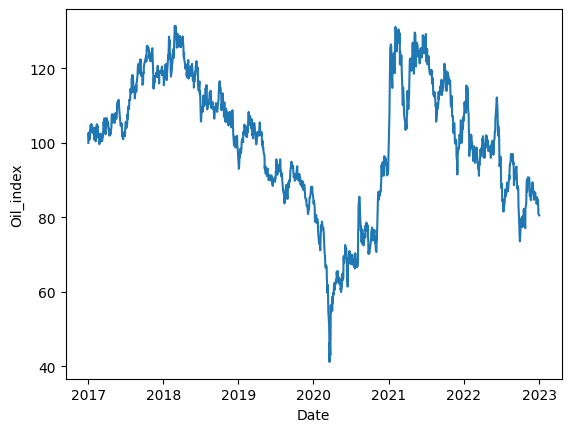

In [36]:
# x축 index값 못 읽음: reset_index 사용
df1_marketcap = df_marketcap.reset_index()
sns.lineplot(df1_marketcap, x='Date', y='Oil_index')

# 두바이유
selenium을 써서 investing.com 데이터를 가져올 수도 있으나 추후 모델 배포시 <br>
selenium이 작동 안할 가능성 높은 관계로 request 사용하여 시도

In [19]:
# investing.com 두바이유
# selenium 사용안하고 페이지 수를 넘길 수 없으므로 불가
import requests
url = "https://kr.investing.com/commodities/dubai-crude-oil-platts-futures-historical-data"
requests.get(url)

<Response [403]>

In [20]:
import urllib.request
url_naver = "https://finance.naver.com/marketindex/worldDailyQuote.naver?marketindexCd=OIL_DU&fdtc=2&page=1"
response = urllib.request.urlopen(url_naver)
html = response.read()
df_dubai = pd.read_html(html)[0]
df_dubai

,날짜,파실 때,보내실 때,받으실 때
0,2023.05.30,72.08,3.43,-4.54%
1,2023.05.26,75.51,0.85,+1.13%
2,2023.05.25,74.66,2.12,-2.76%
3,2023.05.24,76.78,1.56,+2.07%
4,2023.05.23,74.99,0.22,+0.29%
5,2023.05.22,74.77,0.16,+0.21%
6,2023.05.19,74.61,0.15,-0.19%


## 데이터 수집
2017년 1월 1일 데이터까지 수집

In [21]:
import urllib.request
from dateutil import relativedelta 

df_dubai = pd.DataFrame()
# 시작 날짜는 직접 확인해야함(없는 날짜 존재)
oil_start_date = "2017-01-05"
page = 1
while True:
    print("페이지수: ",page, end=" ")
    url_naver = f"https://finance.naver.com/marketindex/worldDailyQuote.naver?marketindexCd=OIL_DU&fdtc=2&page={page}"
    response = urllib.request.urlopen(url_naver)
    html = response.read()
    df_tmp = pd.read_html(html)[0]
    df_tmp['날짜'] = pd.to_datetime(df_tmp['날짜']).dt.date
    print("테이블 시작 날짜: ",df_tmp['날짜'].iloc[0])
    
    df_dubai = pd.concat([df_dubai,df_tmp],axis=0)
    
    # 원하는 날짜 들어있다면 break
    oil_start_date = pd.to_datetime(oil_start_date).date()
    
    if oil_start_date in df_tmp['날짜'].to_list():
        break
        
    # 페이지 넘기기
    page +=1
    
df_dubai

페이지수:  1 테이블 시작 날짜:  2023-05-30
페이지수:  2 테이블 시작 날짜:  2023-05-18
페이지수:  3 테이블 시작 날짜:  2023-05-09
페이지수:  4 테이블 시작 날짜:  2023-04-28
페이지수:  5 테이블 시작 날짜:  2023-04-19
페이지수:  6 테이블 시작 날짜:  2023-04-10
페이지수:  7 테이블 시작 날짜:  2023-03-30
페이지수:  8 테이블 시작 날짜:  2023-03-21
페이지수:  9 테이블 시작 날짜:  2023-03-10
페이지수:  10 테이블 시작 날짜:  2023-03-01
페이지수:  11 테이블 시작 날짜:  2023-02-17
페이지수:  12 테이블 시작 날짜:  2023-02-08
페이지수:  13 테이블 시작 날짜:  2023-01-30
페이지수:  14 테이블 시작 날짜:  2023-01-19
페이지수:  15 테이블 시작 날짜:  2023-01-09
페이지수:  16 테이블 시작 날짜:  2022-12-28
페이지수:  17 테이블 시작 날짜:  2022-12-16
페이지수:  18 테이블 시작 날짜:  2022-12-07
페이지수:  19 테이블 시작 날짜:  2022-11-28
페이지수:  20 테이블 시작 날짜:  2022-11-16
페이지수:  21 테이블 시작 날짜:  2022-11-07
페이지수:  22 테이블 시작 날짜:  2022-10-27
페이지수:  23 테이블 시작 날짜:  2022-10-18
페이지수:  24 테이블 시작 날짜:  2022-10-07
페이지수:  25 테이블 시작 날짜:  2022-09-28
페이지수:  26 테이블 시작 날짜:  2022-09-19
페이지수:  27 테이블 시작 날짜:  2022-09-08
페이지수:  28 테이블 시작 날짜:  2022-08-29
페이지수:  29 테이블 시작 날짜:  2022-08-18
페이지수:  30 테이블 시작 날짜:  2022-08-09
페이지수:  31 테이블 시작 날짜

,날짜,파실 때,보내실 때,받으실 때
0,2023-05-30,72.08,3.43,-4.54%
1,2023-05-26,75.51,0.85,+1.13%
2,2023-05-25,74.66,2.12,-2.76%
3,2023-05-24,76.78,1.56,+2.07%
4,2023-05-23,74.99,0.22,+0.29%
...,...,...,...,...
2,2017-01-05,54.76,0.44,+0.81%
3,2016-12-30,52.09,0.03,-0.06%
4,2016-12-29,52.12,0.01,-0.02%
5,2016-12-28,52.09,0.00,0.00%


In [25]:
df_dubai = df_dubai[['날짜','파실 때']]
df_dubai.columns = ['Date','Oil_price']
df_dubai

,Date,Oil_price
0,2023-05-30,72.08
1,2023-05-26,75.51
2,2023-05-25,74.66
3,2023-05-24,76.78
4,2023-05-23,74.99
...,...,...
2,2017-01-05,54.76
3,2016-12-30,52.09
4,2016-12-29,52.12
5,2016-12-28,52.09


In [26]:
df_dubai['Date'] = pd.to_datetime(df_dubai['Date'])
df_dubai = df_dubai.set_index('Date')
df_dubai = df_dubai.sort_index()
df_dubai

,Oil_price
Date,
2023-05-30,72.08
2023-05-26,75.51
2023-05-25,74.66
2023-05-24,76.78
2023-05-23,74.99
...,...
2017-01-05,54.76
2016-12-30,52.09
2016-12-29,52.12


In [83]:
# df_dubai.to_csv("duabi_naver_2017.csv")

# Oil index 와 석유 가격 데이터프레임

In [37]:
df_marketcap.head()

,096770,010950,011170,078930,161000,005950,002960,025000,004090,014530,003650,000440,024060,total,Oil_index
Date,,,,,,,,,,,,,,,
2017-01-02,8.042646e+12,1.741079e+12,6.998555e+12,2.406106e+12,2.032504e+10,2.355847e+11,2.621782e+11,9.862807e+10,3.087084e+09,6.248743e+09,7.601071e+10,8.098507e+08,651033600.0,1.989191e+13,100.000000
2017-01-03,8.480341e+12,1.790472e+12,7.035053e+12,2.419399e+12,1.976928e+10,2.341721e+11,2.618782e+11,1.020686e+11,3.132680e+09,6.190434e+09,7.519776e+10,8.045402e+08,631276800.0,2.042911e+13,102.700597
2017-01-04,8.535052e+12,1.788414e+12,6.816064e+12,2.375088e+12,2.064262e+10,2.341721e+11,2.594784e+11,1.032154e+11,3.132680e+09,6.073817e+09,7.527905e+10,7.992297e+08,631276800.0,2.021804e+13,101.639531
2017-01-05,8.425629e+12,1.774008e+12,6.788686e+12,2.357363e+12,2.056323e+10,2.313626e+11,2.594784e+11,1.035431e+11,3.102282e+09,6.102971e+09,7.527905e+10,8.164888e+08,626572800.0,2.004656e+13,100.777458
2017-01-06,8.589764e+12,1.790472e+12,6.743068e+12,2.383950e+12,2.056323e+10,2.271404e+11,2.597784e+11,1.056729e+11,3.087084e+09,6.112690e+09,7.495387e+10,7.979021e+08,635040000.0,2.020600e+13,101.578968


In [38]:
df_dubai.head()

,Oil_price
Date,
2023-05-30,72.08
2023-05-26,75.51
2023-05-25,74.66
2023-05-24,76.78
2023-05-23,74.99


## index + oil_price 데이터프레임
* 문제상황: 석유가격은 매일매일 나오지 않을때도 있으며 주말에도 가격이 변하지만 주가의 경우 영업일(Businessday)에만 변화
* 해결: 일일 데이터를 만들고 영업일(Businessday)기준으로 

In [39]:
df_marketcap.index

DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-09', '2017-01-10', '2017-01-11',
               '2017-01-12', '2017-01-13',
               ...
               '2022-12-19', '2022-12-20', '2022-12-21', '2022-12-22',
               '2022-12-23', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2023-01-02'],
              dtype='datetime64[ns]', name='Date', length=1476, freq=None)

In [45]:
df_dubai.index

DatetimeIndex(['2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
               '2017-01-05', '2017-01-06', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2023-05-16', '2023-05-17', '2023-05-18', '2023-05-19',
               '2023-05-22', '2023-05-23', '2023-05-24', '2023-05-25',
               '2023-05-26', '2023-05-30'],
              dtype='datetime64[ns]', name='Date', length=1617, freq=None)

## 시작날(start_date) ~ 마지막날(end_date) index 인덱스 설정 

In [51]:
df_daily = pd.DataFrame(index=pd.date_range(start=start_date,end=end_date))
df_daily

""
2017-01-02
2017-01-03
2017-01-04
2017-01-05
2017-01-06
...
2022-12-29
2022-12-30
2022-12-31
2023-01-01


## Oil_index,두바이유(Oil_price) 합치기

In [60]:
df_total = df_daily.merge(df_marketcap[['Oil_index']], right_index=True,left_index=True ,how='left')
df_total = df_total.merge(df_dubai, right_index=True, left_index=True, how='left')
df_total

,Oil_index,Oil_price
2017-01-02,100.000000,NaN
2017-01-03,102.700597,NaN
2017-01-04,101.639531,NaN
2017-01-05,100.777458,54.76
2017-01-06,101.578968,54.81
...,...,...
2022-12-29,80.932329,78.68
2022-12-30,NaN,81.06
2022-12-31,NaN,NaN
2023-01-01,NaN,NaN


In [61]:
# 주말 공휴일 등 없는 날짜 전날 가격으로 채워주기
df_total = df_total.fillna(method='ffill')
df_total = df_total.fillna(method='bfill')
df_total

,Oil_index,Oil_price
2017-01-02,100.000000,54.76
2017-01-03,102.700597,54.76
2017-01-04,101.639531,54.76
2017-01-05,100.777458,54.76
2017-01-06,101.578968,54.81
...,...,...
2022-12-29,80.932329,78.68
2022-12-30,80.932329,81.06
2022-12-31,80.932329,81.06
2023-01-01,80.932329,81.06


<Axes: title={'center': 'Oil index & Oil price'}>

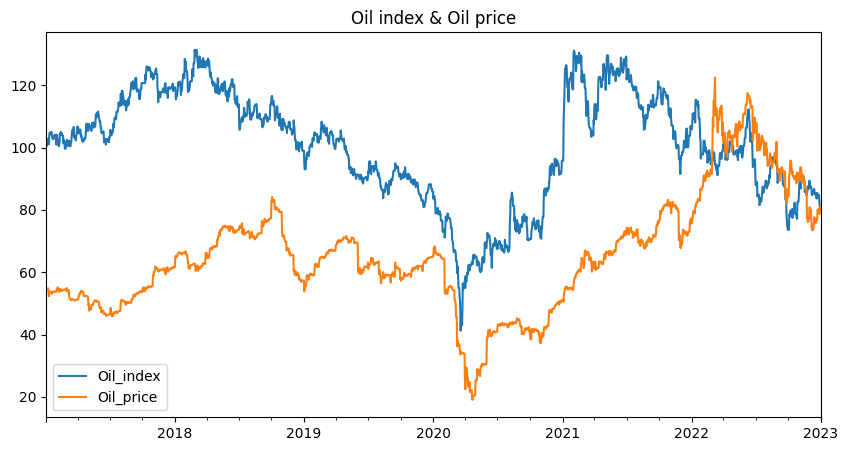

In [71]:
## 시각화
fig,ax = plt.subplots(figsize=(10,5))
df_total.plot(ax=ax, title='Oil index & Oil price')

<Axes: title={'center': 'Oil index & Oil price'}>

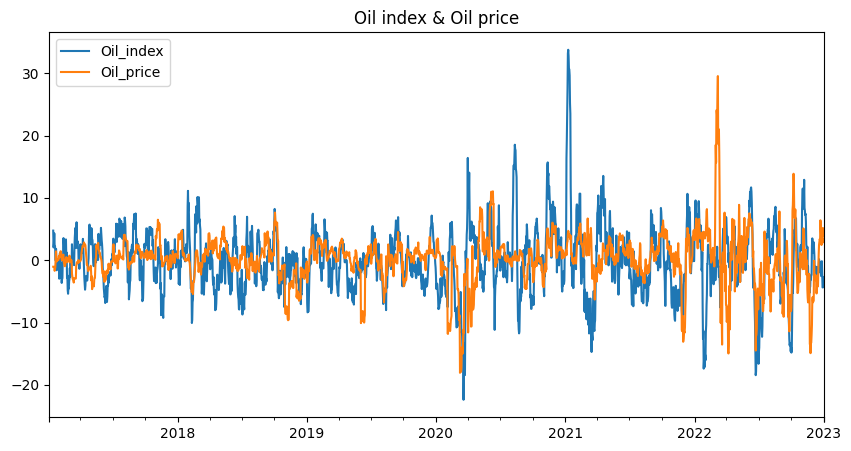

In [72]:
## 시각화
fig,ax = plt.subplots(figsize=(10,5))
df_total.diff(12).plot(ax=ax, title='Oil index & Oil price')

# 선행성 판단
* LSTM 계열의 딥러닝을 사용하기 위해선 두 변수의 선행관계가 분명해야함
* 이를 입증하기 위해 grangercausality 테스트를 진행

In [52]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(df_plot[['전체석유주지수','두바이유 선물종가']], maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2072  , p=0.0227  , df_denom=1105, df_num=1
ssr based chi2 test:   chi2=5.2214  , p=0.0223  , df=1
likelihood ratio test: chi2=5.2091  , p=0.0225  , df=1
parameter F test:         F=5.2072  , p=0.0227  , df_denom=1105, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8429  , p=0.0217  , df_denom=1102, df_num=2
ssr based chi2 test:   chi2=7.7206  , p=0.0211  , df=2
likelihood ratio test: chi2=7.6938  , p=0.0213  , df=2
parameter F test:         F=3.8429  , p=0.0217  , df_denom=1102, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5497  , p=0.0544  , df_denom=1099, df_num=3
ssr based chi2 test:   chi2=7.6977  , p=0.0527  , df=3
likelihood ratio test: chi2=7.6710  , p=0.0533  , df=3
parameter F test:         F=2.5497  , p=0.0544  , df_denom=1099, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3109  , p=0.

{1: ({'ssr_ftest': (5.207241449886223, 0.022682456981045606, 1105.0, 1),
   'ssr_chi2test': (5.221378756989987, 0.022310855045641592, 1),
   'lrtest': (5.209114565540403, 0.02246877468860994, 1),
   'params_ftest': (5.207241449887989, 0.02268245698102004, 1105.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.842880180727019, 0.021719575620501985, 1102.0, 2),
   'ssr_chi2test': (7.720632232422522, 0.021061340639399337, 2),
   'lrtest': (7.693833474216262, 0.02134544871213611, 2),
   'params_ftest': (3.842880180728006, 0.021719575620479985, 1102.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.549650706894008, 0.05440975106313177, 1099.0, 3),
   'ssr_chi2test': (7.697671560941145, 0.052691145052956766, 3),
   'lrtest': (7.671007619448574, 0.05332356691175297, 3),
   'params_ftest': (2.549650706893715, 0.05440975106314915, 1099.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [

In [53]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(df_plot[['두바이유 선물종가','전체석유주지수']], maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.9152 , p=0.0000  , df_denom=1105, df_num=1
ssr based chi2 test:   chi2=16.9611 , p=0.0000  , df=1
likelihood ratio test: chi2=16.8326 , p=0.0000  , df=1
parameter F test:         F=16.9152 , p=0.0000  , df_denom=1105, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.5476  , p=0.0002  , df_denom=1102, df_num=2
ssr based chi2 test:   chi2=17.1727 , p=0.0002  , df=2
likelihood ratio test: chi2=17.0408 , p=0.0002  , df=2
parameter F test:         F=8.5476  , p=0.0002  , df_denom=1102, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.6319  , p=0.0008  , df_denom=1099, df_num=3
ssr based chi2 test:   chi2=17.0032 , p=0.0007  , df=3
likelihood ratio test: chi2=16.8738 , p=0.0008  , df=3
parameter F test:         F=5.6319  , p=0.0008  , df_denom=1099, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.1799  , p=0.

{1: ({'ssr_ftest': (16.915157164160945, 4.198638260810752e-05, 1105.0, 1),
   'ssr_chi2test': (16.961080667774052, 3.8153976997764156e-05, 1),
   'lrtest': (16.832571762149655, 4.082652715158206e-05, 1),
   'params_ftest': (16.91515716416248, 4.1986382608075153e-05, 1105.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (8.547551320703654, 0.00020717828135088443, 1102.0, 2),
   'ssr_chi2test': (17.172666627983567, 0.00018663918182043208, 2),
   'lrtest': (17.040830265332715, 0.00019935664872652628, 2),
   'params_ftest': (8.547551320702047, 0.00020717828135121048, 1102.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (5.631850708864837, 0.00078632027500382, 1099.0, 3),
   'ssr_chi2test': (17.003167108292566, 0.000705683209961607, 3),
   'lrtest': (16.873791717852328, 0.0007502612934598662, 3),
   'params_ftest': (5.631850708863364, 0.0007863202750054465, 1099.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 

In [35]:
# 상관관계
corr = df_plot.corr()
print(corr)

            전체석유주지수  두바이유 선물종가  두바이유 현물종가
전체석유주지수    1.000000   0.612757   0.632371
두바이유 선물종가  0.612757   1.000000   0.988806
두바이유 현물종가  0.632371   0.988806   1.000000


# 모델링

In [36]:
# 일주일 단위로 바꾸기

In [37]:
df_plot.head(3)

,Date,전체석유주지수,두바이유 선물종가,두바이유 현물종가
0,2017-02-10,100.000000,54.59,53.78
1,2017-02-13,100.592569,54.03,54.76
2,2017-02-14,99.697576,54.27,54.14


In [38]:
# df_wplot = df_plot.set_index('Date').loc['2017-2-10':'2022-02-10'].resample('W-MON',label = 'left', closed='right')['전체석유주지수'].last()

# df_wplot = df_wplot.reset_index().rename(columns={'Date':'날짜','전체석유주지수': '주간 전체석유주지수'})
# df_wplot.head(3)

In [39]:
df_wplot = df_plot.set_index('Date').loc['2017-2-10':'2022-02-10'].\
resample('W-MON',label = 'left', closed='right')[['전체석유주지수','두바이유 선물종가','두바이유 현물종가']].last()

df_wplot = df_wplot.reset_index().rename(columns={'Date':'날짜','전체석유주지수': '주간 전체석유주지수'})
df_wplot.head(3)

,날짜,주간 전체석유주지수,두바이유 선물종가,두바이유 현물종가
0,2017-02-06,100.592569,54.03,54.76
1,2017-02-13,99.481612,54.22,54.06
2,2017-02-20,96.121336,54.43,55.18


In [40]:
# 주간 상관관계 : 일일데이터 상관계수보다 조금 낮다

corr_w = df_wplot.corr()
print(corr_w)

            주간 전체석유주지수  두바이유 선물종가  두바이유 현물종가
주간 전체석유주지수    1.000000   0.608721   0.627675
두바이유 선물종가     0.608721   1.000000   0.989353
두바이유 현물종가     0.627675   0.989353   1.000000
